In [16]:
from utils import *
from fastai2.vision.widgets import *
from fastai.vision import *
from fastai2.vision.all import *
import zipfile
from pathlib import Path
from shutil import copyfile

In [2]:
# extract the training data
with zipfile.ZipFile('all-jpegs-no-folders.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')

In [5]:
# don't think we need this: rug_types = ['over','angle','corner_light','corner_grey','corner_dark','back','detail','lifestyle']
path = Path('data/training_images')
len(path.ls())
path.ls()


[Path('data/training_images/06869-0007_07-Detail.jpeg'),
 Path('data/training_images/06846-0005_05-Corner_Dark.jpeg'),
 Path('data/training_images/06875-0004_04-Corner_Grey.jpeg'),
 Path('data/training_images/06846-0005_02-Angle.jpeg'),
 Path('data/training_images/06872-0048_04-Corner_Grey.jpeg'),
 Path('data/training_images/06846-0005_08-Lifestyle.jpeg'),
 Path('data/training_images/06846-0005_03-Corner_Light.jpeg'),
 Path('data/training_images/06778-0001_02-Angle.jpeg'),
 Path('data/training_images/06778-0001_04-Corner_Grey.jpeg'),
 Path('data/training_images/06846-0007_08-Lifestyle.jpeg'),
 Path('data/training_images/06872-0048_07-Detail.jpeg'),
 Path('data/training_images/06869-0007_01-Over.jpeg'),
 Path('data/training_images/06869-0007_06-Back.jpeg'),
 Path('data/training_images/06846-0007_04-Corner_Grey.jpeg'),
 Path('data/training_images/06846-0005_07-Detail.jpeg'),
 Path('data/training_images/06869-0007_08-Lifestyle.jpeg'),
 Path('data/training_images/06834-0007_02-Angle.jpeg')

In [6]:
rugs = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=using_attr(RegexLabeller(r'\d{5}-\d{4}_\d\d-(.+).jpe?g$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=336))
rugs

In [7]:
dls = rugs.dataloaders(path,bs=8)

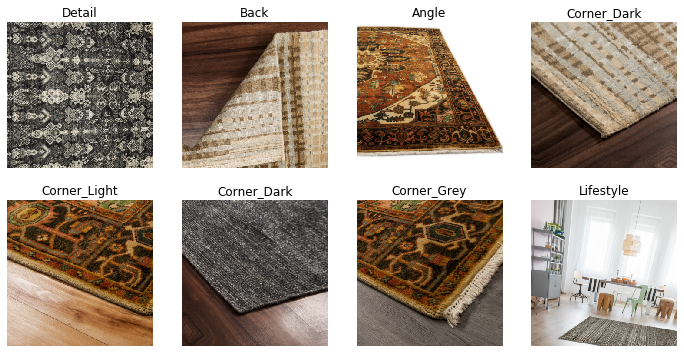

In [6]:
dls.show_batch(max_n=9)

In [7]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,3.015705,1.861225,0.666667,00:28


epoch,train_loss,valid_loss,error_rate,time
0,2.245681,1.266178,0.416667,00:36
1,1.722623,0.671547,0.250000,00:37
2,1.468519,0.508488,0.250000,00:37
3,1.206182,0.498878,0.250000,00:37


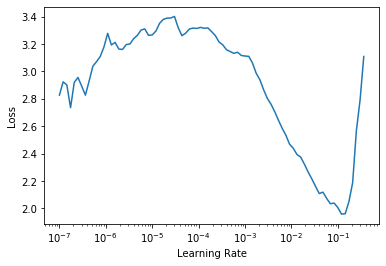

In [8]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()


In [9]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.20e-02, steepest point: 1.10e-06


In [10]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,3.810391,2.890933,0.916667,00:28


epoch,train_loss,valid_loss,error_rate,time
0,2.581576,1.754922,0.666667,00:37
1,2.093338,0.729379,0.166667,00:37
2,1.569023,0.721659,0.333333,00:37
3,1.225669,0.548191,0.333333,00:37


In [11]:
# TO DO: see chapter 5 to better fine-tune the learning so you can lower the error rate
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,3.232725,1.811971,0.833333,00:28
1,2.268107,0.501881,0.083333,00:28
2,1.731447,0.566801,0.250000,00:28


In [12]:
learn.unfreeze()

SuggestedLRs(lr_min=0.0002511886414140463, lr_steep=2.2908675418875646e-06)

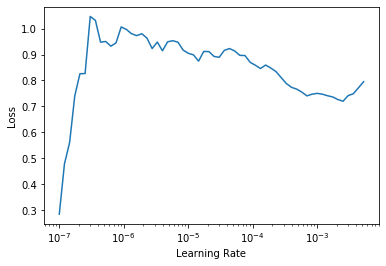

In [13]:
learn.lr_find()

In [14]:
# update learning rate based on what it found above
learn.fit_one_cycle(6, lr_max=7.5e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.751501,0.849967,0.250000,00:37
1,1.060921,7.517735,0.500000,00:37
2,1.049885,5.940554,0.916667,00:37
3,0.957501,4.026423,0.500000,00:37
4,0.834468,1.922609,0.166667,00:37
5,0.787959,0.994046,0.166667,00:37


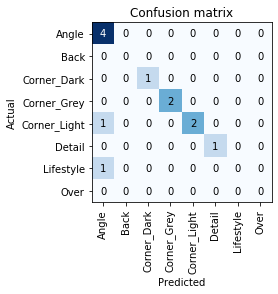

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

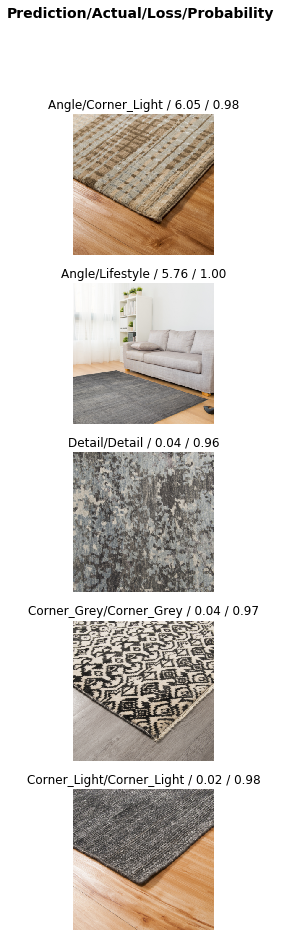

In [16]:
interp.plot_top_losses(5, nrows=5)

In [21]:
# TO DO: see chapter 2 to export the model for production and set up a a script that can make a prediction and rename a file
# learn.export()
learn.save()


NameError: name 'learn' is not defined

In [11]:
root_path = Path()
models_path = Path('models/')
# root_path.ls(file_exts='.pkl')

In [17]:
learn_inf = load_learner(root_path/'models/rug-classifier-aug-08-2020.pkl')
learn_inf

In [76]:
print(learn_inf.dls.vocab)
learn_inf.predict('data/test_images/06882-0001_03.tif') # insert test image here from unclassified group

(#8) ['Angle','Back','Corner_Dark','Corner_Grey','Corner_Light','Detail','Lifestyle','Over']


('Angle',
 tensor(0),
 tensor([9.6491e-01, 2.2278e-07, 2.1416e-02, 1.8529e-04, 3.8291e-03, 6.0185e-06,
         9.6283e-03, 2.4641e-05]))

## Everything in one block

In [23]:
from utils import *
from fastai2.vision.widgets import *
# from fastai.vision import *
from fastai2.vision.all import *
import zipfile
from pathlib import Path
from shutil import copyfile


class TooManyPeriodsInFileName(Exception):
    """Exception raised when a filename being has more than one period (.) in it."""
    def __init__(self,file):
        self.message = "Too many periods in the filename: " + file
    
root_path = Path()

# load the deep learning inference model 
learn_inf = load_learner(root_path/'models/rug-classifier-aug-08-2020.pkl')

test_images_path = Path('data/test_images/')
renamed_images_path = Path('data/renamed_images')

# create a 'renamed_images' folder if it doesn't exist yet
if not os.path.exists(renamed_images_path):
    os.mkdir(renamed_images_path)
    print('\'renamed_images folder\' did not exist but has been created.')
    
files = [file for file in os.listdir(test_images_path)]

for file in files:
    if 'tif' in file:
        path_plus_file = str(test_images_path) + '/' + file
        
        # predict the label using the deep learning model (takes an image as an arg and returns a prediction)
        predicted_label = learn_inf.predict(path_plus_file)[0]
    
        # confirm there was only 1 period in the filename, otherwise things will get messy
        filename_array = file.split('.')
        
        if len(filename_array) > 2:
            raise TooManyPeriodsInFileName(file)
        else:
            file_new_name = filename_array[0] + '_' + predicted_label + '.' + filename_array[1]

        # copy the original to the new folder
        copyfile(path_plus_file, str(renamed_images_path) + '/' + file_new_name)
        print(file_new_name + ' has been created and copied to /' + str(renamed_images_path) + '/')
        

# TO DO: set the main path as the root of where you're running the script?
# TO DO: automate the process so you can process a whole folder or many subfolders

06882-0001_03_Angle.tif has been created and copied to /data/renamed_images/
